# Geographically Weighted Regression (Part II): COVID 19 Mortality

<b>Author:</b>  Naomi W. Lazarus, PhD<br>
<b>Date Created:</b> 6-15-21

This notebook provides the code for running a Geographically Weighted Regression (GWR) using COVID-19 death-case ratios as the dependent variable and independent variables representing age and underlying conditions. It is an exploratory analysis of spatial relationships between COVID-19, age demographics, and comorbidities.  It is not recommended for predictive purposes.

# Notebook Outline

- [Introduction](#Intro)
    - [Install MGWR package](#Install)
    - [Load required packages](#Load)
- [Load and preview data for deat-case ratios for peak period 1](#Peak1)
    - [Preprocess data for GWR](#Data1)
    - [Review GWR Results](#Results1)
- [Load and preview data for death-case ratios for peak period 2](#Peak2)
    - [Preprocess data for GWR](#Data2)
    - [Review GWR Results](#Results2)
- [References](#Ref)

<a id='Intro'></a>
# Introduction

The notebooks consists of two sections.  The first uses covid-19 death-case ratios for peak period 1 (03/01/20 - 04/30/20).  The second uses covid-19 death-case ratios for peak period 2 (06/01/20 - 07/31/20). The following links provide information on file descriptions and metadata. 

[Link to Metadata](Data_Files2/Metadata.txt)<br>
[Link to file descriptions](Data_Files2/Files.txt)


<a id='Install'></a>
## Install MGWR package

In [1]:
try:
    from mgwr.gwr import GWR
except:
    print('Installing MGWR')
    ! pip install -U mgwr


<a id='Load'></a>
## Load required packages

In [2]:
import numpy as np
import pandas as pd
import libpysal as ps
from spreg import OLS
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

<a id='Peak1'></a>
# Load and preview data for death-case ratios for peak period 1

In [3]:
covid_DR1 = gp.read_file('/home/jovyan/shared_data/data/geospatialfellows21/lazarus_data/Data_Files2/Layer_DR1_1.shp')

In [4]:
covid_DR1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,PCT_over75,DIAB_PCT,CARDIO_MR,OBESE_PCT,DR1_log,Shape_Leng,Shape_Area,X,Y,geometry
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,5.4,8.1,186.9,29.9,-0.380211,191498.450302,2.181031e+09,-5.775873e+04,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19..."
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,5.1,8.2,229.2,31.1,-0.230023,186372.852811,2.103144e+09,-6.367993e+04,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53..."
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,534,...,7.1,9.8,296.3,35.9,0.431798,154277.000259,1.375313e+09,1.029369e+06,291980.881448,"POLYGON ((1010444.794 298225.136, 1010431.187 ..."
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,352,...,6.0,13.7,266.0,31.5,1.204120,204211.504278,2.597938e+09,-5.365911e+05,-529891.392654,"POLYGON ((-561065.818 -536037.871, -560987.294..."
4,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,8.3,14.2,452.0,37.1,0.677781,203930.129612,1.568824e+09,9.422905e+05,-583488.845178,"POLYGON ((930647.181 -578247.838, 930643.004 -..."


<a id='Data1'></a>
## Preprocess data for GWR

In [5]:
# Run Ordinary Least Squares Regression

y = covid_DR1['DR1_log'].values.reshape((-1, 1))
X = covid_DR1[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values

In [6]:
ols = OLS(y, X)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:        1445
Mean dependent var  :      0.6915                Number of Variables   :           6
S.D. dependent var  :      0.3642                Degrees of Freedom    :        1439
R-squared           :      0.1142
Adjusted R-squared  :      0.1111
Sum squared residual:     169.686                F-statistic           :     37.1065
Sigma-square        :       0.118                Prob(F-statistic)     :   7.282e-36
S.E. of regression  :       0.343                Log likelihood        :    -502.833
Sigma-square ML     :       0.117                Akaike info criterion :    1017.665
S.E of regression ML:      0.3427                Schwarz criterion     :    1049.320

-----------------------------------------------------------------------------

In [7]:
# Defining variables and coordinates

g_y = covid_DR1['DR1_log'].values.reshape((-1, 1))
g_X = covid_DR1[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values
u = covid_DR1['X']
v = covid_DR1['Y']
g_coords = list(zip(u, v))


In [8]:
# Inspecting the data contents

print('g_y:\n', g_y[:5])
print('\ng_X:\n', g_X[:5])
print('\nu:\n', list(u[:5]))
print('\nv:\n', list(v[:5]))
print('\ng_coords:\n', g_coords[:5], "\n")


g_y:
 [[-0.38021124]
 [-0.23002293]
 [ 0.43179828]
 [ 1.20411998]
 [ 0.67778071]]

g_X:
 [[ 24.7   5.4   8.1 186.9  29.9]
 [ 25.7   5.1   8.2 229.2  31.1]
 [ 29.9   7.1   9.8 296.3  35.9]
 [ 23.8   6.   13.7 266.   31.5]
 [ 33.6   8.3  14.2 452.   37.1]]

u:
 [-57758.7266368, -63679.9337388, 1029369.27457, -536591.069548, 942290.494088]

v:
 [198290.895484, 519393.038636, 291980.881448, -529891.392654, -583488.845178]

g_coords:
 [(-57758.7266368, 198290.895484), (-63679.9337388, 519393.038636), (1029369.27457, 291980.881448), (-536591.069548, -529891.392654), (942290.494088, -583488.845178)] 



In [9]:
# Testing suitable bandwidth prior to specifying the model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)



210.0


In [10]:
# Specifying the GWR model - bandwidth set at 210 neighbors using an adaptive Gaussian kernal function

gwr_model = GWR(g_coords, g_y, g_X, bw=210, fixed=False, kernel='gaussian')
gwr_results = gwr_model.fit()


<a id='Results1'></a>
## Review GWR Results

In [11]:
# Print Global regression results

print(gwr_results.resid_ss)
print(gwr_results.aic)
print(gwr_results.R2)
print(gwr_results.adj_R2)

156.37939932960043
936.4351388419129
0.18366972233771262
0.17023045708720108


In [12]:
# Create a column to store R2 values in the dataframe

covid_DR1['R2'] = gwr_results.localR2   

In [13]:
covid_DR1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,DIAB_PCT,CARDIO_MR,OBESE_PCT,DR1_log,Shape_Leng,Shape_Area,X,Y,geometry,R2
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,8.1,186.9,29.9,-0.380211,191498.450302,2.181031e+09,-5.775873e+04,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.215712
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,8.2,229.2,31.1,-0.230023,186372.852811,2.103144e+09,-6.367993e+04,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.215420
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,534,...,9.8,296.3,35.9,0.431798,154277.000259,1.375313e+09,1.029369e+06,291980.881448,"POLYGON ((1010444.794 298225.136, 1010431.187 ...",0.103319
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,352,...,13.7,266.0,31.5,1.204120,204211.504278,2.597938e+09,-5.365911e+05,-529891.392654,"POLYGON ((-561065.818 -536037.871, -560987.294...",0.240960
4,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,14.2,452.0,37.1,0.677781,203930.129612,1.568824e+09,9.422905e+05,-583488.845178,"POLYGON ((930647.181 -578247.838, 930643.004 -...",0.089116


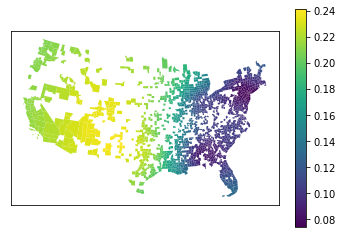

In [14]:
# Visualizing local R2 values on a map

covid_DR1['R2'] = gwr_results.localR2
covid_DR1.plot('R2', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [15]:
# Create a column to store standardized residual values in the dataframe

covid_DR1['SR'] = gwr_results.std_res

In [16]:
covid_DR1.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,CARDIO_MR,OBESE_PCT,DR1_log,Shape_Leng,Shape_Area,X,Y,geometry,R2,SR
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,186.9,29.9,-0.380211,191498.450302,2.181031e+09,-5.775873e+04,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.215712,-2.678272
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,229.2,31.1,-0.230023,186372.852811,2.103144e+09,-6.367993e+04,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.215420,-2.302788
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,534,...,296.3,35.9,0.431798,154277.000259,1.375313e+09,1.029369e+06,291980.881448,"POLYGON ((1010444.794 298225.136, 1010431.187 ...",0.103319,-0.732327
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,352,...,266.0,31.5,1.204120,204211.504278,2.597938e+09,-5.365911e+05,-529891.392654,"POLYGON ((-561065.818 -536037.871, -560987.294...",0.240960,1.929299
4,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,452.0,37.1,0.677781,203930.129612,1.568824e+09,9.422905e+05,-583488.845178,"POLYGON ((930647.181 -578247.838, 930643.004 -...",0.089116,-0.208833


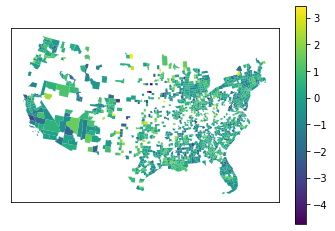

In [17]:
# Visualizing standardized residuals on a map

covid_DR1['SR'] = gwr_results.std_res
covid_DR1.plot('SR', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
# Reviewing parameter estimates associated with the predictors starting with the constant.
# B coefficients follow the sequence of predictors listed in code sample for OLS regression

print(gwr_results.params)

[[ 0.02055622  0.0123105   0.0463624  -0.0043402   0.00085611 -0.00654612]
 [ 0.03526271  0.01245452  0.04679122 -0.00439508  0.00076873 -0.0065212 ]
 [ 0.29912958  0.01347439 -0.00420925 -0.00249183  0.0008089  -0.00594659]
 ...
 [ 0.20903462  0.00425762  0.02809669 -0.00662472  0.00051505  0.00184494]
 [ 0.05717097  0.00867551  0.03830898 -0.00782702  0.00091113 -0.00184074]
 [ 0.20592389  0.01314867 -0.00787042 -0.00202249  0.00072701 -0.00238278]]


<a id='Peak2'></a>
# Load and preview data for death-case ratios for peak period 2

In [19]:
covid_DR2 = gp.read_file('/home/jovyan/shared_data/data/geospatialfellows21/lazarus_data/Data_Files2/Layer_DR2_1.shp')

In [20]:
covid_DR2.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,PCT_over75,DIAB_PCT,CARDIO_MR,OBESE_PCT,DR2_log,Shape_Leng,Shape_Area,X,Y,geometry
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,5.4,8.1,186.9,29.9,-0.411620,191498.450302,2.181031e+09,-5.775873e+04,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19..."
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,5.1,8.2,229.2,31.1,0.245761,186372.852811,2.103144e+09,-6.367993e+04,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53..."
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,534,...,7.1,9.8,296.3,35.9,-0.403121,154277.000259,1.375313e+09,1.029369e+06,291980.881448,"POLYGON ((1010444.794 298225.136, 1010431.187 ..."
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,352,...,6.0,13.7,266.0,31.5,0.207998,204211.504278,2.597938e+09,-5.365911e+05,-529891.392654,"POLYGON ((-561065.818 -536037.871, -560987.294..."
4,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,8.3,14.2,452.0,37.1,0.246672,203930.129612,1.568824e+09,9.422905e+05,-583488.845178,"POLYGON ((930647.181 -578247.838, 930643.004 -..."


<a id='Data2'></a>
## Preprocess data for GWR

In [21]:
# Run Ordinary Least Squares Regression

y = covid_DR2['DR2_log'].values.reshape((-1, 1))
X = covid_DR2[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values

In [22]:
ols = OLS(y, X)
print(ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :     dep_var                Number of Observations:        1964
Mean dependent var  :      0.2395                Number of Variables   :           6
S.D. dependent var  :      0.4085                Degrees of Freedom    :        1958
R-squared           :      0.0725
Adjusted R-squared  :      0.0701
Sum squared residual:     303.829                F-statistic           :     30.5928
Sigma-square        :       0.155                Prob(F-statistic)     :   4.785e-30
S.E. of regression  :       0.394                Log likelihood        :    -954.115
Sigma-square ML     :       0.155                Akaike info criterion :    1920.231
S.E of regression ML:      0.3933                Schwarz criterion     :    1953.727

-----------------------------------------------------------------------------

In [23]:
# Defining variables and coordinates

g_y = covid_DR2['DR2_log'].values.reshape((-1, 1))
g_X = covid_DR2[['PCT_50to74', 'PCT_over75', 'DIAB_PCT', 'CARDIO_MR', 'OBESE_PCT']].values
u = covid_DR2['X']
v = covid_DR2['Y']
g_coords = list(zip(u, v))

In [24]:
# Inspecting the data contents

print('g_y:\n', g_y[:5])
print('\ng_X:\n', g_X[:5])
print('\nu:\n', list(u[:5]))
print('\nv:\n', list(v[:5]))
print('\ng_coords:\n', g_coords[:5], "\n")

g_y:
 [[-0.41161971]
 [ 0.24576091]
 [-0.40312052]
 [ 0.20799764]
 [ 0.24667233]]

g_X:
 [[ 24.7   5.4   8.1 186.9  29.9]
 [ 25.7   5.1   8.2 229.2  31.1]
 [ 29.9   7.1   9.8 296.3  35.9]
 [ 23.8   6.   13.7 266.   31.5]
 [ 33.6   8.3  14.2 452.   37.1]]

u:
 [-57758.7266368, -63679.9337388, 1029369.27457, -536591.069548, 942290.494088]

v:
 [198290.895484, 519393.038636, 291980.881448, -529891.392654, -583488.845178]

g_coords:
 [(-57758.7266368, 198290.895484), (-63679.9337388, 519393.038636), (1029369.27457, 291980.881448), (-536591.069548, -529891.392654), (942290.494088, -583488.845178)] 



In [25]:
# Testing suitable bandwidth prior to specifying the model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search()
print(gwr_bw)

137.0


In [26]:
# Specifying the GWR model - bandwidth set at 137 neighbors using an adaptive Gaussian kernal function

gwr_model = GWR(g_coords, g_y, g_X, bw=137, fixed=False, kernel='gaussian')
gwr_results = gwr_model.fit()


<a id='Results2'></a>
## Review GWR Results 

In [27]:
# Print Global regression results

print(gwr_results.resid_ss)
print(gwr_results.aic)
print(gwr_results.R2)
print(gwr_results.adj_R2)

238.80146905675383
1527.909375355621
0.2709801868733682
0.2537446704171984


In [28]:
# Create a column to store R2 values in the dataframe

covid_DR2['R2'] = gwr_results.localR2   

In [29]:
covid_DR2.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,DIAB_PCT,CARDIO_MR,OBESE_PCT,DR2_log,Shape_Leng,Shape_Area,X,Y,geometry,R2
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,8.1,186.9,29.9,-0.411620,191498.450302,2.181031e+09,-5.775873e+04,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.198936
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,8.2,229.2,31.1,0.245761,186372.852811,2.103144e+09,-6.367993e+04,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.178228
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,534,...,9.8,296.3,35.9,-0.403121,154277.000259,1.375313e+09,1.029369e+06,291980.881448,"POLYGON ((1010444.794 298225.136, 1010431.187 ...",0.122082
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,352,...,13.7,266.0,31.5,0.207998,204211.504278,2.597938e+09,-5.365911e+05,-529891.392654,"POLYGON ((-561065.818 -536037.871, -560987.294...",0.195827
4,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,14.2,452.0,37.1,0.246672,203930.129612,1.568824e+09,9.422905e+05,-583488.845178,"POLYGON ((930647.181 -578247.838, 930643.004 -...",0.118513


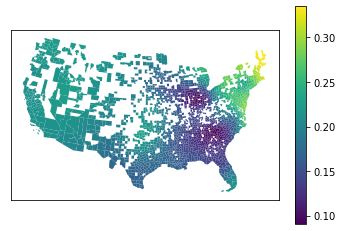

In [30]:
# Visualizing local R2 values on a map

covid_DR2['R2'] = gwr_results.localR2
covid_DR2.plot('R2', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [31]:
# Create a column to store standardized residual values in the dataframe

covid_DR2['SR'] = gwr_results.std_res

In [32]:
covid_DR2.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,...,CARDIO_MR,OBESE_PCT,DR2_log,Shape_Leng,Shape_Area,X,Y,geometry,R2,SR
0,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,...,186.9,29.9,-0.411620,191498.450302,2.181031e+09,-5.775873e+04,198290.895484,"POLYGON ((-76484.353 198568.818, -76478.478 19...",0.198936,-1.306488
1,46,099,01265772,46099,Minnehaha,Minnehaha County,06,H1,G4020,None,...,229.2,31.1,0.245761,186372.852811,2.103144e+09,-6.367993e+04,519393.038636,"POLYGON ((-71439.032 538818.414, -71405.569 53...",0.178228,0.591529
2,39,063,01074044,39063,Hancock,Hancock County,06,H1,G4020,534,...,296.3,35.9,-0.403121,154277.000259,1.375313e+09,1.029369e+06,291980.881448,"POLYGON ((1010444.794 298225.136, 1010431.187 ...",0.122082,-1.881861
3,48,189,01383880,48189,Hale,Hale County,06,H1,G4020,352,...,266.0,31.5,0.207998,204211.504278,2.597938e+09,-5.365911e+05,-529891.392654,"POLYGON ((-561065.818 -536037.871, -560987.294...",0.195827,0.179054
4,01,027,00161539,01027,Clay,Clay County,06,H1,G4020,None,...,452.0,37.1,0.246672,203930.129612,1.568824e+09,9.422905e+05,-583488.845178,"POLYGON ((930647.181 -578247.838, 930643.004 -...",0.118513,0.036173


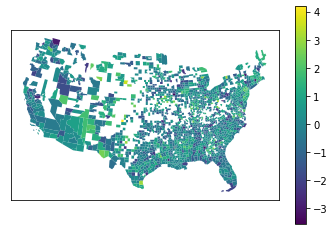

In [33]:
# Visualizing standardized residuals on a map

covid_DR2['SR'] = gwr_results.std_res
covid_DR2.plot('SR', legend = True)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

In [34]:
# Reviewing parameter estimates associated with the predictors starting with the constant.
# B coefficients follow the sequence of predictors listed in code sample for OLS regression

print(gwr_results.params)

[[-5.02611094e-01  5.24705809e-03  7.32579820e-02  1.13759636e-02
  -2.42140122e-04 -7.82225838e-04]
 [-6.19709399e-01  1.13934678e-02  5.86066821e-02  2.33113008e-02
  -2.75864098e-04 -1.97789575e-03]
 [-2.49159254e-01  9.35977020e-03  2.37851084e-02  5.76797632e-03
   6.29925513e-04 -5.16324797e-03]
 ...
 [-4.24822295e-01  1.28331385e-02 -6.95080871e-03 -1.92003250e-03
   4.21660311e-04  2.30771390e-03]
 [-7.43754824e-01  5.77516666e-03  3.53089758e-02 -2.00991505e-03
   2.89997506e-04  1.11455559e-02]
 [-1.47399103e-01  1.18450569e-03  5.65793421e-02 -1.65446961e-03
   9.48437676e-05 -2.50506640e-03]]


<a id='Ref'></a>
### References

Environmental Systems Research Institute (ESRI). (2021). How Geographically Weighted Regression (GWR) works. https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/how-geographicallyweightedregression-works.htm#GUID-A5307DAE-12AF-41C2-831B-10192ECB6CE4. Accessed Jun 15th, 2021

Fotheringham, A.S., Brunsdon, C., and Charlton, M. (2002). Geographically Weighted Regression. West Sussex, U.K.: John Wiley & Sons Ltd. 

Multiscale Geographically Weighted Regression (MGWR). (2018). https://mgwr.readthedocs.io/en/latest/generated/mgwr.gwr.GWRResults.html#mgwr.gwr.GWRResults. Accessed Jun 15th, 2021

Ndiath, M.M., Cisse, B., Ndiaye, J.L., Gomis, J.F., Bathiery, O., Dia, A. T., Gaye, O., and Faye, B. (2015).Application of geographically‑weighted regression analysis to assess risk factors for malaria hotspots in Keur Soce health and demographic surveillance site. Malaria Journal, 14:463. doi:10.1186/s12936-015-0976-9

Oshan, T.M., Li, Z., Kang, W., Wolf, L.J., and Fotheringham, A.S. (2019). MGWR: A Python Implementation of Multiscale
GeographicallyWeighted Regression for Investigating Process Spatial Heterogeneity and Scale. International Journal of Geo-Information, 8:269. doi:10.3390/ijgi8060269  


Spatial Regression Models (spreg). (2018). https://pysal.org/spreg/generated/spreg.OLS.html#spreg.OLS. Accessed Jun 15th, 2021
